# Multi Head Attention

In [17]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

In [2]:
sequence_length = 4
batch_size = 1
input_dim = 512
d_model = 512
x = torch.randn( (batch_size, sequence_length, input_dim) )

In [3]:
x.size()

torch.Size([1, 4, 512])

In [4]:
qkv_layer = nn.Linear(input_dim, 3 * d_model)

In [5]:
qkv = qkv_layer(x)

In [6]:
qkv.shape

torch.Size([1, 4, 1536])

In [7]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins=200, min=-3, max=3)


Text(0.5, 1.0, 'qkv distribution')

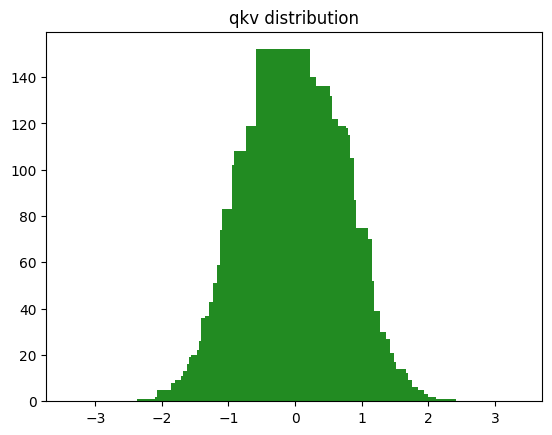

In [8]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3
plt.bar(x_val, y_val, align='center', color=['forestgreen'])
plt.title('qkv distribution')

In [11]:
num_heads = 8
head_dim = d_model //num_heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3* head_dim)

In [12]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [13]:
qkv = qkv.permute(0, 2, 1, 3)
qkv.shape

torch.Size([1, 8, 4, 192])

In [14]:
q, k, v = qkv.chunk(3, dim=-1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

# Self attention for multiple heads

In [18]:
d_k = q.size()[-1]
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 4, 4])

In [20]:
k.T.shape # This transposes the whole matrix and not the last 2 dims

torch.Size([64, 4, 8, 1])

In [24]:
y = torch.randn(2, 3)
y

tensor([[-2.7823, -0.0465,  0.7955],
        [ 1.4217,  0.5805, -0.0134]])

In [28]:
torch.transpose(y, 0, 1)

tensor([[-2.7823,  1.4217],
        [-0.0465,  0.5805],
        [ 0.7955, -0.0134]])

In [29]:
torch.transpose(y, 1, 0)

tensor([[-2.7823,  1.4217],
        [-0.0465,  0.5805],
        [ 0.7955, -0.0134]])

In [30]:
k.transpose(-1, -2) == k.transpose(-2, -1)

tensor([[[[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         ...,

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, 

In [31]:
k.transpose(-1, -2).shape

torch.Size([1, 8, 64, 4])

In [40]:
mask = torch.full(scaled.size(), float('-inf'))
mask = torch.triu(mask, diagonal=1)
mask[0][1] #Second masked attention head of the first batch

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [51]:
(scaled + mask)[0][0] #First masked attention head of the first batch

tensor([[ 0.2910,    -inf,    -inf,    -inf],
        [ 0.2216, -0.1857,    -inf,    -inf],
        [ 0.0345,  0.5100,  0.1362,    -inf],
        [-0.3748,  0.0925, -0.1228,  0.3434]], grad_fn=<SelectBackward0>)

In [52]:
scaled += mask

In [57]:
# Calculating softmax of the second row
x = scaled[0][0][1][0].detach().numpy()
y = scaled[0][0][1][1].detach().numpy()
np.exp(x) / (np.exp(x) + np.exp(y))

0.6004411

In [58]:
attention = F.softmax(scaled, dim=-1)

In [59]:
attention.shape

torch.Size([1, 8, 4, 4])

In [60]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.6004, 0.3996, 0.0000, 0.0000],
        [0.2691, 0.4330, 0.2979, 0.0000],
        [0.1685, 0.2690, 0.2168, 0.3457]], grad_fn=<SelectBackward0>)

In [61]:
values = torch.matmul(attention, v)
values.shape

torch.Size([1, 8, 4, 64])

# Function

In [62]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [63]:
values, attention = scaled_dot_product(q, k, v, mask=mask)

In [64]:
attention.shape

torch.Size([1, 8, 4, 4])

In [65]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.6004, 0.3996, 0.0000, 0.0000],
        [0.2691, 0.4330, 0.2979, 0.0000],
        [0.1685, 0.2690, 0.2168, 0.3457]], grad_fn=<SelectBackward0>)